# 📡 Sarcasm detector

Dataset original source:

- [Kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)

Build a predictive model

- Compare: NB, KNN, SVM

Theorical sources

- [NB](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [KNN](https://www.codecademy.com/learn/introduction-to-supervised-learning-skill-path/modules/k-nearest-neighbors-skill-path/cheatsheet)
- [SVM](https://es.wikipedia.org/wiki/M%C3%A1quinas_de_vectores_de_soporte)
- [ROC curve](https://stackabuse.com/understanding-roc-curves-with-python/)

Sklearn references

- [Column Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html)
- [One Hot Encoder](https://datagy.io/sklearn-one-hot-encode/)
- [Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
- [NB](https://scikit-learn.org/stable/modules/naive_bayes.html)
- [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
- [Hyper parameter tunning](https://medium.com/@kocur4d/hyper-parameter-tuning-with-pipelines-5310aff069d6)

## 🏷 TOC:
* [Libraries](#libraries)
* [The data](#the-data)
* [Exploratory data analysis](#exploratory-data-analysis)
* [How to vectorize text](#how-to-vectorize-text)
* [End to end modeling](#end-to-end-modeling)
* [Conclusions](#conclusions)

## 📝 Libraries <a class="anchor" id="libraries"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
import scipy
from time import time

import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

## 🔡 The data <a class="anchor" id="the-data"></a>

In [2]:
dataset_name = 'Sarcasm_Headlines_Dataset.json'
X_a = pd.read_json(dataset_name, lines=True)

In [3]:
X_a.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## 🕵 Exploratory data analysis <a class="anchor" id="exploratory-data-analysis"></a>

In [4]:
X_a.shape

(26709, 3)

In [5]:
X_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [6]:
X_a.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

### Get ride of duplicated headlines

In [7]:
X_a['headline'].duplicated().sum()

107

In [8]:
X_a[X_a['headline'].duplicated()].index

Int64Index([ 1091,  2265,  2975,  3802,  4605,  5154,  5789,  6383,  6642,
             6685,
            ...
            25115, 25118, 25855, 25995, 26026, 26121, 26156, 26353, 26500,
            26615],
           dtype='int64', length=107)

In [9]:
X_a = X_a.drop(X_a[X_a['headline'].duplicated()].index, axis=0)

In [10]:
X_a['headline'].duplicated().sum()

0

In [11]:
X_a.shape

(26602, 3)

### Get ride of duplicate features

#### The transmitter

In [12]:
df = X_a.copy()

In [13]:
extract_transmitter = lambda url : url.split('.')[1]
df['transmitter'] = df['article_link'].apply(extract_transmitter)
df.head()

,article_link,headline,is_sarcastic,transmitter
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


#### Sarcastic distribution

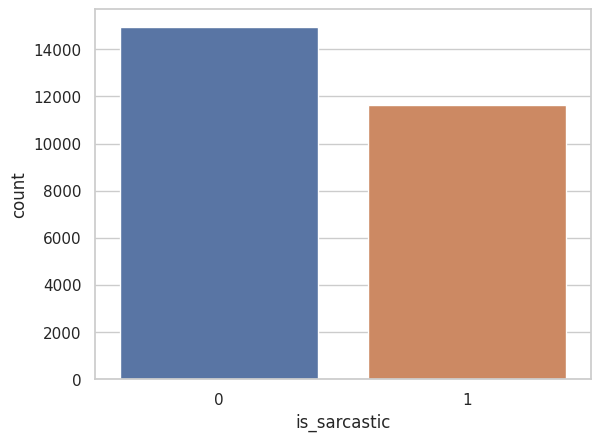

In [14]:
# here I notice that the dependent variable is unbalanced.
# there are arround 4K more samples of non sarcastic headlines
sns.set_theme(style='whitegrid')
ax = sns.countplot(x='is_sarcastic', data=df)

#### Transmitter distribution

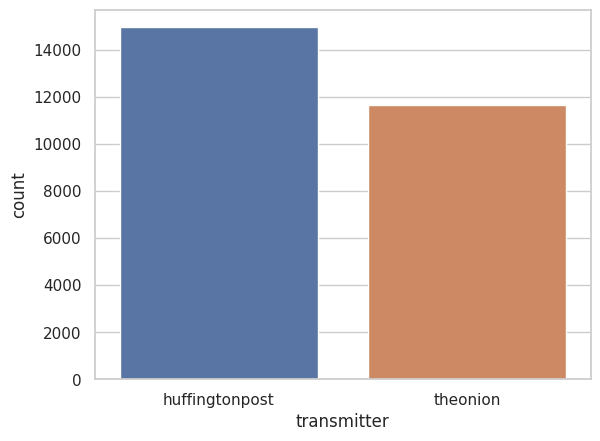

In [15]:
# here I notice that the dependent variable is unbalanced. Not that much yet unbalanced
sns.set_theme(style='whitegrid')
ax = sns.countplot(x='transmitter', data=df)

#### Linear correlation between features

I noticed that the countplots from **trasnsmitter distribution** and **sarcastic distribution** are quite similar. I want to know if they are that much related

In [16]:
from pandas import factorize

columns = ['transmitter', 'is_sarcastic']
X = df[columns]
X.loc[:, 'transmitter'] = factorize(X['transmitter'])[0]

It's important to note that a matrix of all ones is a very unlikely scenario in real-world data, as it would indicate that all of the variables are perfectly related and there is no variability or uniqueness in the data. However, with this information I deduce that **theonion** source always throw sarcastic headlines meanwhile **huffingtonpost** always gives non-sarcastic headlines.

The conclusion here is that if I mantein the **transmitter** feature created from feature engineering I am more like to create an acurate model with the disatventage to need the source emitter.

In [17]:
# calculate the correlation matrix
corr = X.corr()
corr

,transmitter,is_sarcastic
transmitter,1.0,1.0
is_sarcastic,1.0,1.0


## 🔨 How to vectorize text? <a class="anchor" id="how-to-vectorize-text"></a>

In this section I present the way I map from raw text to vectorized samples in order to inject the vectorized samples into M.L models

### Denoise headlines

In this section I present the way I clean the text and transform to simple phrases using the **nltk** library and removing stop words

In [18]:
def denoise_text(text: str):
    
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer, WordNetLemmatizer
    
    def concat(tokens):
        return ' '.join(tokens)

    # lower case
    text = text.lower()
    
    # remove punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # remove numbers
    tokens = [token for token in tokens if not token.isnumeric()]
    
    # remove stop words
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    
    # stem words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return concat(tokens)

In [19]:
df['clean_headline'] = df['headline'].apply(denoise_text)
df[['headline', 'clean_headline']].head(10)

,headline,clean_headline
0,former versace store clerk sues over secret 'b...,former versac store clerk sue secret black cod...
1,the 'roseanne' revival catches up to our thorn...,roseann reviv catch thorni polit mood better wors
2,mom starting to fear son's web series closest ...,mom start fear son web seri closest thing gran...
3,"boehner just wants wife to listen, not come up...",boehner want wife listen come altern debt redu...
4,j.k. rowling wishes snape happy birthday in th...,j k rowl wish snape happi birthday magic way
5,advancing the world's women,advanc world woman
6,the fascinating case for eating lab-grown meat,fascin case eat lab grown meat
7,"this ceo will send your kids to school, if you...",ceo send kid school work compani
8,top snake handler leaves sinking huckabee camp...,top snake handler leav sink huckabe campaign
9,friday's morning email: inside trump's presser...,friday morn email insid trump presser age


### Most commond words in headlines

In this section you'll see the most recurrent words used in sarcastic headlines and in not sarcastic headlines. This may gives us an idea of how sarcastic quotes are diferenciated from non sarcastic quotes.

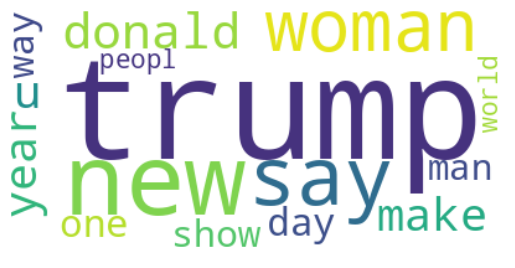

In [20]:
# more frequent words used in not sarcastic headlines
ns_words = ' '.join(df[df['is_sarcastic'] == 0]['clean_headline'])
wc = WordCloud(max_words = 15, collocations = False, background_color = 'white').generate(ns_words)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

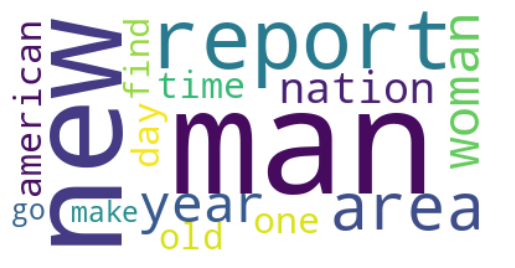

In [21]:
# more frequent words used in sarcastic headlines
ns_words = ' '.join(df[df['is_sarcastic'] == 1]['clean_headline'])
wc = WordCloud(max_words = 15, collocations = False, background_color = 'white').generate(ns_words)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Vectorize words

To add context to the machine learning algorithm, I use ngrams of size 1 and 2. This makes increase the size of data but I hope it helps the algoritms to be more acurate.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = df['clean_headline']
vectorizer = CountVectorizer(dtype='int32', analyzer='word', ngram_range=(1,2))
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

In [23]:
X.shape

(26602, 146989)

In [24]:
feature_names[100:125]

array(['31st age', '34th', '34th anniversari', '34th season',
       '34th short', '350th', '350th anniversari', '35th',
       '35th anniversari', '35th year', '37th', '37th sailor', '38c',
       '38c episod', '393rd', '393rd guilti', '3d', '3d model',
       '3d print', '3d printer', '3d world', '3m', '3m introduc', '3po',
       '3po red'], dtype=object)

In [25]:
feature_names[100000:100025]

array(['pressur self', 'pressur senat', 'pressur sleep', 'pressur stanc',
       'pressur use', 'pressur wife', 'prestigi', 'prestigi honor',
       'prestigi univers', 'preston', 'preston cook', 'presum',
       'presum innoc', 'presum man', 'presumpt', 'presumpt cruelli',
       'presumpt prepar', 'presumpt republican', 'pretend',
       'pretend care', 'pretend everyth', 'pretend faint',
       'pretend frazzl', 'pretend fuck', 'pretend hear'], dtype=object)

In [26]:
# X.toarray() <- Even decreasing the number of bits to representing the data, it does not work, I have 8gb of ram and it exceeds 14gb
sdf = pd.DataFrame.sparse.from_spmatrix(X)
sdf[['is_sarcastic', 'transmitter']] = df[['is_sarcastic', 'transmitter']]

In [27]:
sdf[list(range(10)) + ['is_sarcastic', 'transmitter']].head()

,0,1,2,3,4,5,6,7,8,9,is_sarcastic,transmitter
0,0,0,0,0,0,0,0,0,0,0,0.0,huffingtonpost
1,0,0,0,0,0,0,0,0,0,0,0.0,huffingtonpost
2,0,0,0,0,0,0,0,0,0,0,1.0,theonion
3,0,0,0,0,0,0,0,0,0,0,1.0,theonion
4,0,0,0,0,0,0,0,0,0,0,0.0,huffingtonpost


## 🔮 End to End Modeling<a class="anchor" id="end-to-end-modeling"></a>

As I want this project be portable, I'll use the end-to-end desing pattern. Which, being brief, consist in having the transformations and the modeling in the same workflow, programmatically as I'm using **sklearn**, it means using *Pipelines* and *Transformers*.

### Transformations

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformers

# cleans noise from raw text
class TextDenoiser(BaseEstimator, TransformerMixin):
    
    def __denoise_text(self, text):
        from nltk.tokenize import RegexpTokenizer
        from nltk.corpus import stopwords
        from nltk.stem import PorterStemmer, WordNetLemmatizer
        
        def concat(tokens):
            return ' '.join(tokens)

        # lower case
        text = text.lower()

        # remove punctuation
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)

        # remove numbers
        tokens = [token for token in tokens if not token.isnumeric()]

        # remove stop words
        stop_words = stopwords.words('english')
        tokens = [token for token in tokens if token not in stop_words]

        # stem words
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

        # lemmatize words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return concat(tokens)

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        for c in X.columns:
            X[c] = X[c].apply(self.__denoise_text)
        return X

    
# Transform url into transmitter categorical variable 
# (NOT USED ANYMORE as I see this features give me height performance but It makes models dependent from this variable and I dont want it!)
class TransmitterExtracter(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # self.input_features = X.columns
        return self
    
    def __extracter(self, text):
        return text.split('.')[1]

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        for c in X.columns:
            X[c] = X[c].apply(self.__extracter)
        return X

In [29]:
text_processor_pipeline = Pipeline(steps=[
            ('denoiser', TextDenoiser()),
            ('ct', ColumnTransformer(transformers=[
                ('v', CountVectorizer(dtype='int32', analyzer='word', ngram_range=(1,2)), 0)])
            )
        ])

# Column transformer get's ride of no transformed columns
preprocessor = ColumnTransformer(
    transformers=[
        #('tf1', transmitter_processor_pipeline, ['article_link']),
        ('tf2', text_processor_pipeline, ['headline']),
    ],
    #remainder='passthrough'
)

In [30]:
# To remember what we had until now
X_a.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [31]:
X = X_a.drop(['is_sarcastic', 'article_link'], 1)
y = X_a['is_sarcastic']
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.to_numpy())

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

type(X_train), type(y_train)

(scipy.sparse._csr.csr_matrix, pandas.core.series.Series)

In [33]:
print('Training dataset shape features', X_train.shape)
print('Training dataset shape labels', y_train.shape)
print('Test dataset shape features', X_test.shape)
print('Test dataset shape labels', y_test.shape)

Training dataset shape features (21281, 121431)
Training dataset shape labels (21281,)
Test dataset shape features (5321, 121431)
Test dataset shape labels (5321,)


### Modeling

In [34]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

I import some metrics to know how good my models behave. As the default distribution of my data is unbalanced I'll use **f1** score as the trusted metric estimator

In [35]:
from sklearn.model_selection import RandomizedSearchCV

Because I rather work with Jupyterlab instead of Google Collab and I need my machine I'll use RandomizedSearchCV instead of GridSearchCV in order to pick random params and accelerate the train process. I also lower the CV validations splits to 3 instead of 5 which is the default.

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.to_numpy())

I use the 20% of the original sample to make the test. The splited samples are not randomly, it uses stratify mechanism as we know that the data is a litte biassed, because we have more samples of non-sarcastic quotes. If I do this, I force that the distribution in the test samples follow this rule

In [37]:
# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_test, predictions, classes):
    cm = confusion_matrix(y_test, predictions, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classes)
    disp.plot()
    plt.show()

AUC–ROC curve is the model selection metric for bi–multi class classification problem. 
ROC is a probability curve for different classes. ROC tells us how good the model is 
for distinguishing the given classes, in terms of the predicted probability.
The area covered by the curve is the area between the orange line (ROC) and the axis. 
This area covered is AUC. The bigger the area covered, the better the machine learning models is at distinguishing the given classes. 
ideal value for AUC is 1.

In [38]:
def plot_roc_curve(pipe, X_test, y_test):
    from sklearn.metrics import RocCurveDisplay
    _ = RocCurveDisplay.from_estimator(pipe, X_test, y_test)

In [39]:
# Here I some information from different models
M = {}

### Naive Bayes

There are two variants of Naive Bayes model that are suitable to use in text classification problems

- [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)
- [Complement Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes)

#### Multinomial NB

In [40]:
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('mnb', MultinomialNB())
])

grid_params = {
  'mnb__alpha': np.linspace(0.5, 1.5, 10),
  'mnb__fit_prior': [True, False],  
}
start=time()
rsp = RandomizedSearchCV(
    pipe, 
    grid_params, 
    random_state = 74, 
    cv = 3,
    scoring = 'f1'
)
rsp.fit(X_train, y_train)
elapsed = time() - start
print("CV trainning took: ", round(elapsed, 2), " seconds")

CV trainning took:  208.41  seconds


In [41]:
print("Best Params: ", rsp.best_params_)
print("Best Estimator: ", rsp.best_estimator_)

Best Params:  {'mnb__fit_prior': False, 'mnb__alpha': 0.5}
Best Estimator:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tf2',
                                                  Pipeline(steps=[('denoiser',
                                                                   TextDenoiser()),
                                                                  ('ct',
                                                                   ColumnTransformer(transformers=[('v',
                                                                                                    CountVectorizer(dtype='int32',
                                                                                                                    ngram_range=(1,
                                                                                                                                 2)),
                                                                                                

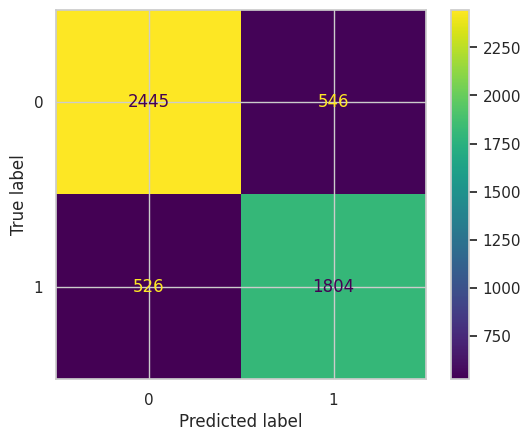

In [42]:
pipe = rsp.best_estimator_
y_pred = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_pred, pipe.classes_)

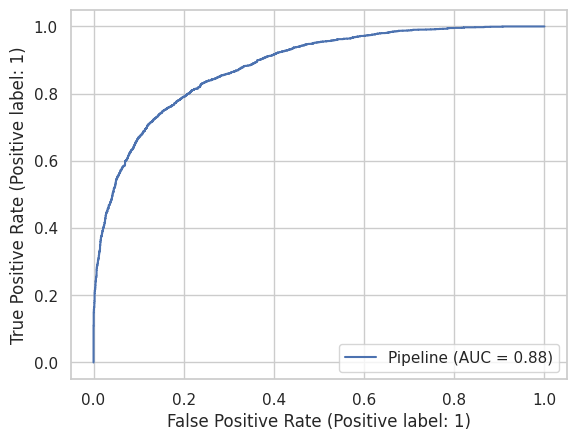

In [45]:
plot_roc_curve(pipe, X_test, y_test)

In [46]:
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('f1 score: ', '{}%'.format(round(f1 * 100, 2)))
print('accuracy: ', '{}%'.format(round(accuracy * 100, 2)))

f1 score:  77.09%
accuracy:  79.85%


In [47]:
M['multinomial_nb'] = {
    'best_params': rsp.best_params_,
    'best_estimator': rsp.best_estimator_,
    'trainning_time': elapsed,
    'f1_score': f1,
    'accuracy': accuracy
}

#### Complement NB

In [48]:
from sklearn.naive_bayes import ComplementNB
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('cnb', ComplementNB())
])

grid_params = {
  'cnb__alpha': np.linspace(0.5, 1.5, 10),
  'cnb__fit_prior': [True, False],
  'cnb__norm': [True, False],  
}
start=time()
rsp = RandomizedSearchCV(
    pipe, 
    grid_params, 
    random_state = 74, 
    cv = 3,
    scoring = 'f1'
)
rsp.fit(X_train, y_train)
elapsed = time() - start
print("CV trainning took: ", round(elapsed, 2), " seconds")

CV trainning took:  200.36  seconds


In [49]:
print("Best Params: ", rsp.best_params_)
print("Best Estimator: ", rsp.best_estimator_)

Best Params:  {'cnb__norm': False, 'cnb__fit_prior': False, 'cnb__alpha': 1.0555555555555556}
Best Estimator:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tf2',
                                                  Pipeline(steps=[('denoiser',
                                                                   TextDenoiser()),
                                                                  ('ct',
                                                                   ColumnTransformer(transformers=[('v',
                                                                                                    CountVectorizer(dtype='int32',
                                                                                                                    ngram_range=(1,
                                                                                                                                 2)),
                                                             

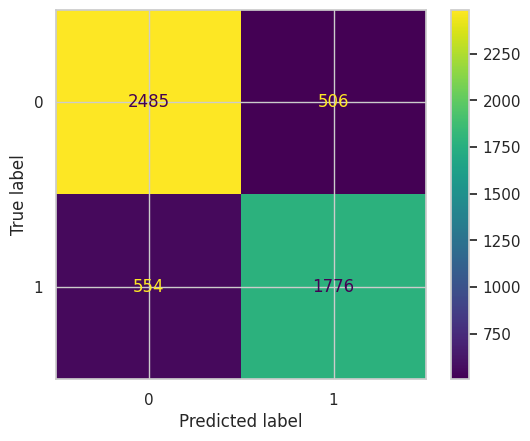

In [50]:
pipe = rsp.best_estimator_
y_pred = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_pred, pipe.classes_)

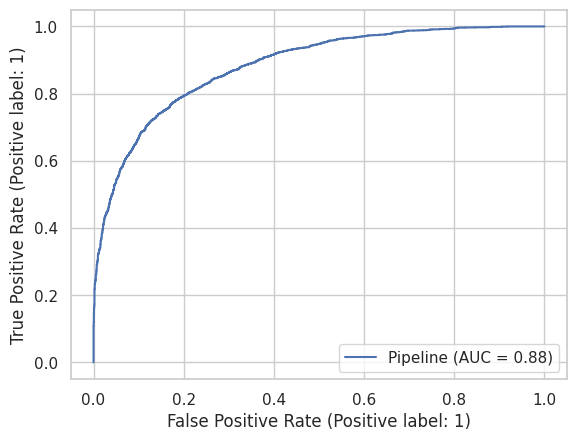

In [51]:
plot_roc_curve(pipe, X_test, y_test)

In [52]:
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('f1 score: ', '{}%'.format(round(f1 * 100, 2)))
print('accuracy: ', '{}%'.format(round(accuracy * 100, 2)))

f1 score:  77.02%
accuracy:  80.08%


In [53]:
M['complement_nb'] = {
    'best_params': rsp.best_params_,
    'best_estimator': rsp.best_estimator_,
    'trainning_time': elapsed,
    'f1_score': f1_score,
    'accuracy': accuracy
}

### KNN

In [54]:
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

grid_params = {
  'knn__n_neighbors': list(range(1,4)),
  'knn__weights': ('uniform', 'distance')
}

start=time()
rsp = RandomizedSearchCV(
    pipe, 
    grid_params, 
    random_state = 74, 
    cv = 3,
    scoring = 'f1'
)
rsp.fit(X_train, y_train)
elapsed = time() - start
print("CV trainning took: ", round(elapsed, 2), " seconds")

CV trainning took:  171.39  seconds


In [55]:
print("Best Params: ", rsp.best_params_)
print("Best Estimator: ", rsp.best_estimator_)

Best Params:  {'knn__weights': 'uniform', 'knn__n_neighbors': 1}
Best Estimator:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tf2',
                                                  Pipeline(steps=[('denoiser',
                                                                   TextDenoiser()),
                                                                  ('ct',
                                                                   ColumnTransformer(transformers=[('v',
                                                                                                    CountVectorizer(dtype='int32',
                                                                                                                    ngram_range=(1,
                                                                                                                                 2)),
                                                                                          

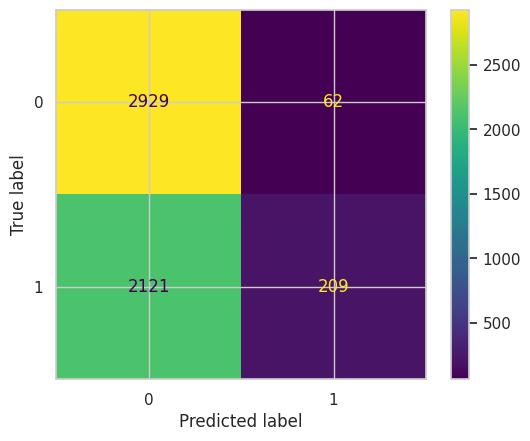

In [56]:
pipe = rsp.best_estimator_
y_pred = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_pred, pipe.classes_)

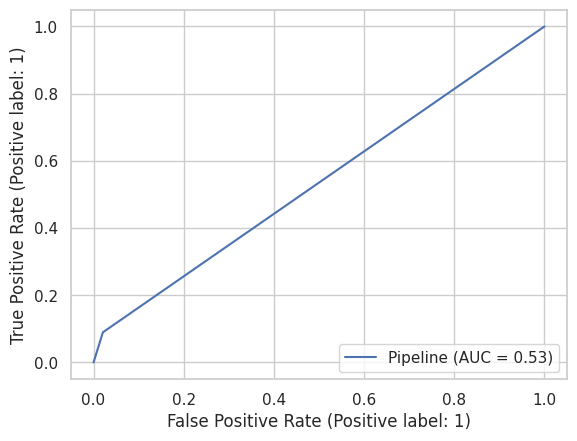

In [57]:
plot_roc_curve(pipe, X_test, y_test)

In [58]:
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('f1 score: ', '{}%'.format(round(f1 * 100, 2)))
print('accuracy: ', '{}%'.format(round(accuracy * 100, 2)))

f1 score:  16.07%
accuracy:  58.97%


In [59]:
M['knn_classifier'] = {
    'best_params': rsp.best_params_,
    'best_estimator': rsp.best_estimator_,
    'trainning_time': elapsed,
    'f1_score': f1_score,
    'accuracy': accuracy
}

### SVM

In [60]:
from sklearn.svm import SVC

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC())
])

grid_params = {
    'svc__C': list(range(1,7,2)),
    'svc__kernel': ('linear', 'sigmoid'),
}
                   
start=time()
rsp = RandomizedSearchCV(
    pipe, 
    grid_params, 
    random_state = 74, 
    cv = 3,
    scoring = 'f1'
)
rsp.fit(X_train, y_train)
elapsed = time() - start
print("CV trainning took: ", round(elapsed, 2), " seconds")

CV trainning took:  1394.07  seconds


In [61]:
print("Best Params: ", rsp.best_params_)
print("Best Estimator: ", rsp.best_estimator_)

Best Params:  {'svc__kernel': 'sigmoid', 'svc__C': 3}
Best Estimator:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tf2',
                                                  Pipeline(steps=[('denoiser',
                                                                   TextDenoiser()),
                                                                  ('ct',
                                                                   ColumnTransformer(transformers=[('v',
                                                                                                    CountVectorizer(dtype='int32',
                                                                                                                    ngram_range=(1,
                                                                                                                                 2)),
                                                                                                    0

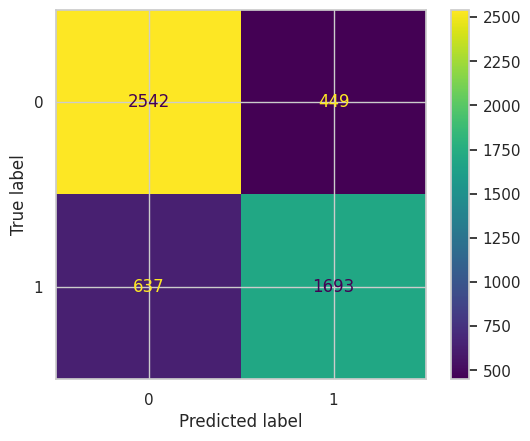

In [62]:
pipe = rsp.best_estimator_
y_pred = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_pred, pipe.classes_)

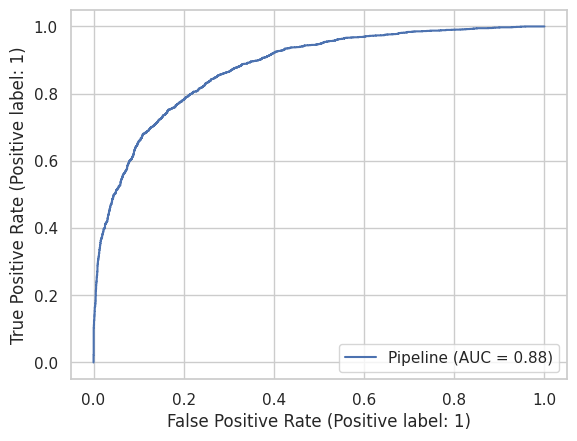

In [63]:
plot_roc_curve(pipe, X_test, y_test)

In [64]:
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('f1 score: ', '{}%'.format(round(f1 * 100, 2)))
print('accuracy: ', '{}%'.format(round(accuracy * 100, 2)))

f1 score:  75.72%
accuracy:  79.59%


In [65]:
M['svm_classifier'] = {
    'best_params': rsp.best_params_,
    'best_estimator': rsp.best_estimator_,
    'trainning_time': elapsed,
    'f1_score': f1_score,
    'accuracy': accuracy
}

## 🧐 Conclusions <a class="anchor" id="conclusions"></a>

In [66]:
M

{'multinomial_nb': {'best_params': {'mnb__fit_prior': False,
   'mnb__alpha': 0.5},
  'best_estimator': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('tf2',
                                                    Pipeline(steps=[('denoiser',
                                                                     TextDenoiser()),
                                                                    ('ct',
                                                                     ColumnTransformer(transformers=[('v',
                                                                                                      CountVectorizer(dtype='int32',
                                                                                                                      ngram_range=(1,
                                                                                                                                   2)),
                                                    